# ✨ Apresentação

**Curso**: Machine Learning


**Alunas**: Camila Perazzo (RA:23022407)  e Sara Bandeira (RA:23022315)

**Atividade de Implementação de modelos e verificação de eficiência da estratégia adotada com utilização de redes neurais - 16/06/2023.**

# 🎯 Questões

### Passos a seguir:

1. Faça a importação do conjunto de dados a partir do dataset fornecido.
2. Importe as bibliotecas necessárias: pandas, numpy, torch, torchvision, etc.
3. Carregue o conjunto de dados usando a biblioteca Pandas.
4. Realize o pré-processamento necessário no conjunto de dados, incluindo a categorização dos valores da coluna "popularity" em três classes (0, 1 e 2) usando a função pd.cut.
5. Realize a codificação one-hot das colunas "artist" e "top genre" usando a função onehot_encode.
6. Separe o conjunto de dados em recursos (X) e rótulos de destino (y). Descarte as colunas irrelevantes para o modelo.
7. Converta os dados para tensores do PyTorch.
8. Crie uma classe CTDataset que herda torch.utils.data.Dataset e implemente os métodos __init__, __len__ e __getitem__ para representar o conjunto de dados.
7. Divida o conjunto de dados em conjuntos de treinamento, validação e teste usando a função random_split do PyTorch, de acordo com as proporções especificadas.
8. Crie carregadores de dados (DataLoader) para cada conjunto, com um tamanho de lote (batch size) adequado.
9. Defina a arquitetura da rede neural no PyTorch, incluindo as camadas Linear necessárias.
10. Defina a função de perda (loss function) como CrossEntropyLoss e o otimizador como Adam.
11. Mova o modelo para a GPU, se disponível, para acelerar o treinamento.
12. Execute o treinamento do modelo por um número específico de épocas, calculando a perda média ao longo das iterações de treinamento.
13. Avalie o desempenho do modelo nos conjuntos de validação e teste, calculando a acurácia, precisão, recall e exibindo o relatório de classificação.
15. Discuta as descobertas e faça uma reflexão sobre a aplicação do PyTorch em problemas de classificação de dados do mundo real.

# 💡 Resolução

In [ ]:
%%time
#===============================================================
# Questão 1
#===============================================================
file = 'Best Songs on Spotify from 2000-2023.csv'
#===============================================================
# Questão 2
#===============================================================
import statistics as stats
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import OneHotEncoder
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,precision_score,recall_score, classification_report
#===============================================================
# Questão 3
#===============================================================
df = pd.read_csv(file, delimiter=';')
#===============================================================
# Questão 4
#===============================================================
df = df.dropna()
df = df.drop_duplicates()
# Categorizar a coluna "popularity"
# criando dataframe para a variável target e outro para os dados para usar nos passos posteriores
dftarget = df.copy()
dftarget['popularity'] = pd.cut(dftarget['popularity'],
                                bins=[min(dftarget['popularity']), stats.median(dftarget['popularity']), max(dftarget['popularity']), np.inf],
                                labels=[0, 1, 2],include_lowest=True)
#===============================================================
# Questão 5
#===============================================================
#Método OneHotEncoding para as 2 variaveis em que foi aplicado
ohe = OneHotEncoder()
feature_arry = ohe.fit_transform(df[['artist']]).toarray()
feature_labels = np.array(ohe.categories_).ravel()
df_ohe = pd.DataFrame(feature_arry,columns=feature_labels)
df = pd.concat([ df, df_ohe],axis=1)

ohe = OneHotEncoder()
feature_arry = ohe.fit_transform(df[['top genre']]).toarray()
feature_labels = np.array(ohe.categories_).ravel()
df_ohe = pd.DataFrame(feature_arry,columns=feature_labels)
df = pd.concat([ df, df_ohe],axis=1)

CPU times: user 48 ms, sys: 990 µs, total: 49 ms
Wall time: 49.1 ms


In [ ]:
#===============================================================
# Questão 6
#===============================================================
# # Fazer escolha das variáveis pela variância dos dados
df =  df.drop(columns=['artist','top genre'])
lista_variaveis = []
for column in  df.drop(columns=['popularity','title']).columns:
  lista_variaveis.append([ df.drop(columns=['popularity'])[column].var(),column])
lista_variaveis = sorted(lista_variaveis,reverse=True)
print(lista_variaveis[:5])

[[1868.547918337484, 'duration'], [743.8206217550969, 'bpm'], [504.36554071166273, 'valence'], [411.18699541316676, 'acousticness'], [261.29457388881855, 'energy']]


In [ ]:
#===============================================================
# Questão 6 (Continuaçao)
#===============================================================
# Foram escolhidas 5 Variáveis: duration, bpm, valence, acousticness, energy.
df = df[['duration','bpm','valence','acousticness','energy']]
# Separar X e y em arquivos para proximas etapas
# Foi criado o  dftarget para o target e o df para as variaveis
#  dftarget no arquivo target e df em new
# esses arquivos sao transformados para numpy e depois seus dados imputados na classe CTDataset
dftarget =  dftarget[['popularity']]
dftarget.to_csv('target_csv.csv', sep=',', index=False, encoding='utf-8')
df.to_csv("new_csv.csv", sep=',', index=False, encoding='utf-8')
#dados em numpy
df_np = np.loadtxt('new_csv.csv', dtype= np.float32, delimiter=",", skiprows=1)
dftarget_np = np.loadtxt('target_csv.csv', dtype= np.float32, delimiter=",", skiprows=1)

In [ ]:
#===============================================================
# Questão 7
#===============================================================
#dados em tensor torch
df_torch = torch.from_numpy(df_np)
dftarget_torch = torch.from_numpy( dftarget_np)
#===============================================================
# Questão 8
#===============================================================
class CTDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    def __len__(self):
        return len(self.features)
    def __getitem__(self, index):
        X = self.features[index]
        y = self.labels[index]
        return X, y
# dados pela classe CTDataset
dataset = CTDataset(df_torch,  dftarget_torch)
#===============================================================
# Questão 9
#===============================================================
# taxas para divisao: treino 70% dados, validaçao 15% e teste 15%
# Foi escolhido 70% pois traz mais dados que 60% e menos que 80%
# uma vez que a rede neural precisa de muitos dados para aprender
# e nao incorrer em cenario de underfitting
# mas também pode aprender demais incorrendo em cenario de
#overfitting
# o restante foi dividido entre teste e validaçao com 15% para cada
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15
# Divisao dos dados
num_samples = len(dataset)
train_size = int(train_ratio * num_samples)
val_size = int(val_ratio * num_samples)
test_size = (len(dataset) - train_size - val_size)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
#===============================================================
# Questão 10
#===============================================================
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
#===============================================================
# Questão 11
#===============================================================
#model
class RedeNeural(nn.Module):
    def __init__(self):
        super(RedeNeural, self).__init__()
        self.fc1 = nn.Linear(5, 640)
        self.fc2 = nn.Dropout(p=0.05)
        self.fc3 = nn.Linear(640, 320)
        self.fc4 = nn.Dropout(p=0.05)
        self.fc5 = nn.Linear(320, 3)
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        #funçao relu
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        x = self.fc5(x)
        return x
model = RedeNeural()
#===============================================================
# Questão 12
#===============================================================
criterion = nn.CrossEntropyLoss()
#Learning rate escolhida de 0.005
optimizer = optim.Adam(model.parameters(), lr=0.005)
#===============================================================
# Questão 13
#===============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

RedeNeural(
  (fc1): Linear(in_features=5, out_features=640, bias=True)
  (fc2): Dropout(p=0.05, inplace=False)
  (fc3): Linear(in_features=640, out_features=320, bias=True)
  (fc4): Dropout(p=0.05, inplace=False)
  (fc5): Linear(in_features=320, out_features=3, bias=True)
)

In [ ]:
%%time
#===============================================================
# Questão 14
#===============================================================
#100 epocas escolhidas
epocas = 100
lista_perdas = []
for epoca in range(epocas):
    epoca_loss = 0.00
    for features, popularity in train_loader:
        features = features.to(device)
        popularity = (popularity.to(device)).long()
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, popularity)
        loss.backward()
        optimizer.step()
        epoca_loss += loss.item()
    lista_perdas.append(round(epoca_loss/len(train_loader),3))
    #perda média ao longo das iteraçoes considera o tamanho usado pra o treino
    print('A Epoca é : ',(epoca+1/epocas),' e a perda média na iteraçao é: ',round(epoca_loss/len(train_loader),3) )

A Epoca é :  0.01  e a perda média na iteraçao é:  35.625
A Epoca é :  1.01  e a perda média na iteraçao é:  1.909
A Epoca é :  2.01  e a perda média na iteraçao é:  0.783
A Epoca é :  3.01  e a perda média na iteraçao é:  0.804
A Epoca é :  4.01  e a perda média na iteraçao é:  0.695
A Epoca é :  5.01  e a perda média na iteraçao é:  0.688
A Epoca é :  6.01  e a perda média na iteraçao é:  0.696
A Epoca é :  7.01  e a perda média na iteraçao é:  0.785
A Epoca é :  8.01  e a perda média na iteraçao é:  0.684
A Epoca é :  9.01  e a perda média na iteraçao é:  0.69
A Epoca é :  10.01  e a perda média na iteraçao é:  0.688
A Epoca é :  11.01  e a perda média na iteraçao é:  0.69
A Epoca é :  12.01  e a perda média na iteraçao é:  0.683
A Epoca é :  13.01  e a perda média na iteraçao é:  0.689
A Epoca é :  14.01  e a perda média na iteraçao é:  0.689
A Epoca é :  15.01  e a perda média na iteraçao é:  0.691
A Epoca é :  16.01  e a perda média na iteraçao é:  0.687
A Epoca é :  17.01  e a p

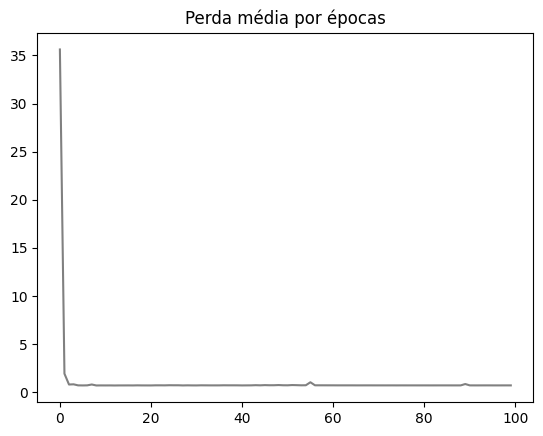

In [ ]:
#===============================================================
# Questão 14 (Continuaçao Plot)
#===============================================================
plt.plot(range(100),lista_perdas,color='gray')
plt.title('Perda média por épocas')
plt.savefig('épocas.pdf')
plt.show()

O eixo X o 0 corresponde a 5 época e sao represetadas 95.


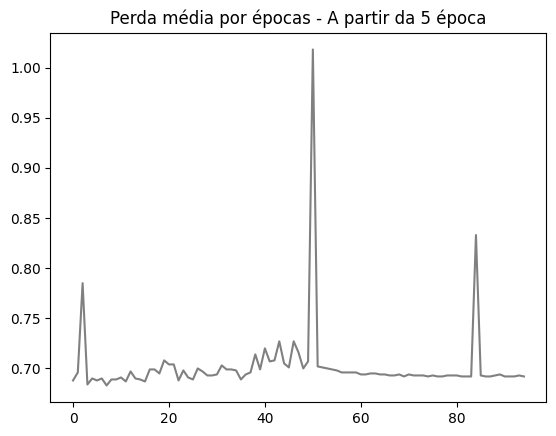

In [ ]:
#===============================================================
# Questão 14 (Continuaçao Plot)
#===============================================================
plt.plot(range(95),lista_perdas[5:],color='gray')
plt.title('Perda média por épocas - A partir da 5 época')
print("O eixo X o 0 corresponde a 5 época e sao represetadas 95.")
plt.savefig('5 épocas.pdf')
plt.show()

In [ ]:
#===============================================================
# Questão 15
#===============================================================
import warnings
warnings.filterwarnings("ignore")
#model.eval()
predicted_labels = []
true_labels = []
#calculo pelo torch dos preditos corretos e do total
with torch.no_grad():
    for features, popularity in test_loader:
        features = features.to(device)
        popularity = popularity.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.cpu().numpy())  # Collect predicted labels
        true_labels.extend(popularity.cpu().numpy())  # Collect true labels

acuracia = 100 * accuracy_score(true_labels,predicted_labels)
precisao = 100*precision_score(true_labels, predicted_labels, average='weighted')
recall = 100*recall_score(true_labels, predicted_labels, average='weighted')
class_report = classification_report(true_labels, predicted_labels)
print("Acuracia: ",round(acuracia,2), " Precisao: ", round(precisao,2), "Recall", round(recall,2))
report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(class_report)

Acuracia:  51.81  Precisao:  26.84 Recall 51.81
Classification Report:
              precision    recall  f1-score   support

         0.0       0.52      1.00      0.68       186
         1.0       0.00      0.00      0.00       173

    accuracy                           0.52       359
   macro avg       0.26      0.50      0.34       359
weighted avg       0.27      0.52      0.35       359



**Questao 16)**

**Discuta as descobertas e faça uma reflexão sobre a aplicação do PyTorch em problemas de classificação de dados do mundo real.**

Quanto à classificação dos dados das classes obtidas pela variável popularity do conjunto de dados utilizado, o desempenho do modelo foi em torno de 51% de acurácia. Foram consideradas 3 classes, o que pode ter impactado nesse desempenho. Do conjunto de dados todo, foram selecionadas 5 features como variáveis preditoras, as quais apresentaram uma maior variabilidade nos dados.


A precisão, que considera a taxa verdadeiros positivos por todos positivos, foi em torno de 26%. O recall foi em torno de 51%. Esses resultados indicam que se a recall foi maior que a precisão, existe um número menor de falsos negativos que falsos positivos (FN < FP).


Quanto a perda média por épocas, elas reduziram a cada iteração, apresentando no gráfico *Perda Média por épocas* uma queda maior após as primeiras épocas. Foi considerado 100 épocas para assegurar que o modelo poderia aprender melhor. Vale notar que esse resultado foi obtido usando a função de ativação ReLu. Nota-se pelo segundo gráfico plotado a partir da 5 época que a variação foi estabilizada quando o número de épocas foi entre 60 e 80, demonstrando que esse poderia ser um valor de época adotado ao invés de 100, pois o modelo já demonstrou uma estabilização no aprendizado a partir da 60.


O Pytorch é um framework que suporta problemas de deep learning com dados em formato de tensor. Problemas que não se sabe as features ou que não precisam tanto da interpretabilidade do modelo, mas dos resultados dele, que seja ideal que o modelo apresente um baixo viés ou ainda que tenham uma quantidade expressiva de dados disponíveis se enquadram em problemas que favorecem a adoção para modelos de deep learning e por isso provavelmente podem ser criadas soluções computacionais através do pytorch.


Alguns casos de problemas que podem ser citados se encaixam em aplicações tais quais o processamento de linguagem natural, tecnologias de fala e visão computacional. Todas essas áreas utilizam redes neurais, seja para aprender o padrão nos dados das palavras, o reconhecimento de sinais e a detecção de objetos. O Pytorch permite a construção dos tensores e tem uma rápida performance, o que beneficia sua adoção nestes casos.

Por fim, uma solução computacional existente, usada na indústria e comunidade científica, que se baseia no Pytorch é o **Detectron2**. Ela é aplicada em tarefas de visão computacional e detecção de objetos e foi desenvolvida pelo Facebook AI Research. Ele consiste num framework para tarefas de detecção, segmentação, inclusive semântica, e reconhecimento visual. Além disso, Detectron2 oferece uma API flexível e extensível para personalização e experimentação rápida. Isso permitiu a adoção generalizada do framework em várias aplicações do mundo real, incluindo sistemas de segurança baseados em vídeo, análise de tráfego, detecção de objetos em tempo real em câmeras de veículos autônomos e muito mais.


A escolha do PyTorch como base para o Detectron2 demonstra a adequação, a confiança e o sucesso da biblioteca no campo de visão computacional. A flexibilidade, eficiência computacional e a comunidade ativa do PyTorch têm contribuído para o desenvolvimento de soluções inovadoras e de alto desempenho para desafios complexos em detecção de objetos e outras tarefas de visão computacional.